In [53]:
import pandas as pd
import numpy as np

In [54]:
import matplotlib.pyplot as plt

In [55]:
from sklearn.linear_model import LinearRegression

In [85]:
import requests

# GSPC

In [69]:
df = pd.read_csv('data/^GSPC.csv')

In [70]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-01,16.660000,17.090000,16.650000,17.049999,17.049999,42570000
1,1950-02-01,17.049999,17.350000,16.990000,17.219999,17.219999,33430000
2,1950-03-01,17.240000,17.610001,17.070000,17.290001,17.290001,40410000
3,1950-04-01,17.340000,18.070000,17.340000,18.070000,18.070000,48250000
4,1950-05-01,18.219999,18.780001,18.110001,18.780001,18.780001,45080000


In [71]:
df['Adj Close Diff'] = df['Adj Close']/df['Adj Close'].shift()

In [5]:
df['Log Adj Close Diff'] = np.log(df['Adj Close Diff'])

In [6]:
np.exp(df['Log Adj Close Diff'].mean())**12

1.0766989707555843

In [7]:
1.03**(1/12)

1.0024662697723037

# What happens if every period I either:
* put the excess revenue (over average revenue) and put in safe investment (3%) or 
* put funds from the safe investment to reach average revenuem

In [8]:
class State():
    def __init__(self, price):
        self.invest = price
        self.invest_history = [self.invest]
        self.safe = 0
        self.safe_history = [self.safe]

    def sell(self, revenue, expected_revenue):
        # put excess revenue in safe
        excess_revenue = expected_revenue - revenue
        self.invest -= excess_revenue
        self.safe += excess_revenue

    def buy(self, revenue, expected_revenue):
        # put funds in investment
        funds = expected_revenue - revenue
        self.invest += funds
        self.safe -= funds
        


def smoothify(prices):
    diffs = prices/prices.shift()
    av = np.exp(np.mean(np.log(diffs)))
    print(av)
    state = State(prices[0])
    for diff,price in zip(diffs[1:],prices[1:]):
#         print('----------')
#         print(price)
        expected_revenue = state.invest*av - state.invest
#         print(expected_revenue)
        revenue = state.invest*diff - state.invest
#         print(revenue)
        state.invest *= av
#         print(state.invest)
        state.invest_history.append(state.invest)
        state.safe *= 1.0024
#         print(state.safe)
        state.safe_history.append(state.safe)
        excess_revenue = expected_revenue - revenue
        state.safe += excess_revenue

    return state
            
state = smoothify(df['Adj Close'])
        
            

1.0061773224372066


In [9]:
s = pd.Series(state.invest_history)

In [10]:
(s/s.shift()).mean()

1.0061773224372177

In [11]:
s_safe = pd.Series(state.safe_history)

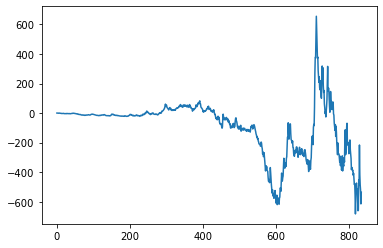

In [13]:
plt.plot(state.safe_history)

In [14]:
0.08/12

0.006666666666666667

In [15]:
df = df.dropna()

In [16]:
def min_take(sample_size=12*40, x=1000000, t=0.07):
    sample = df.sample(sample_size)
    takes = []
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = x*t/12
        x-=take
        takes.append(take)
    return min(takes)

In [17]:
min_takes = [min_take() for _ in range(1000)]

In [18]:
sum(min_takes)/len(min_takes)

3617.6754068050036

(array([ 10.,  65., 117., 173., 154., 150., 133., 110.,  84.,   4.]),
 array([ 602.08549502, 1211.09958806, 1820.11368109, 2429.12777412,
        3038.14186715, 3647.15596018, 4256.17005321, 4865.18414625,
        5474.19823928, 6083.21233231, 6692.22642534]),
 <a list of 10 Patch objects>)

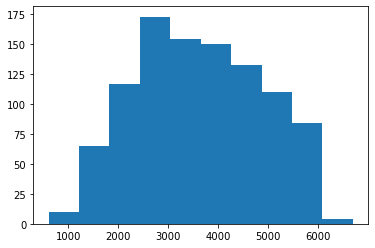

In [19]:
plt.hist(min_takes)

# Bankrupcy experiments

## Constant withdrawal

In [20]:
def is_bankrupt(t=0.05, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    take = x*t/12
    for diff in sample['Adj Close Diff']:
        x*=diff
        x-=take
        if x<0:
            return True
    return False

In [21]:
bankrupcies = [is_bankrupt() for _ in range(100)]

In [22]:
sum(bankrupcies)/len(bankrupcies)

0.12

In [23]:
def get_bankrupcy_prob(t, s=12*40, N=100):
    bankrupcies = [is_bankrupt(t, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [24]:
bankrupcy_probs = [get_bankrupcy_prob(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]]

In [25]:
bankrupcy_probs

[0.0, 0.0, 0.01, 0.02, 0.05, 0.21, 0.38, 0.7, 0.68, 0.85]

## Constant percent of savings withdrawal

In [26]:
def is_bankrupt2(t=0.07, min_take_ratio=.3, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    min_take = min_take_ratio*x*t/12
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = x*t/12
        x-=take
        if take<min_take:
            return True
    return False

In [27]:
def get_bankrupcy_prob2(t, m=.5, s=12*40, N=100):
    bankrupcies = [is_bankrupt2(t, m, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [28]:
bankrupcy_probs = [get_bankrupcy_prob2(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]]

In [29]:
bankrupcy_probs

[0.0, 0.01, 0.01, 0.01, 0.1, 0.16, 0.28, 0.53, 0.75, 0.87]

## Flexible withdrawal

Withdraw a fixed percent down to a minimal withdrawal ratio

In [30]:
def is_bankrupt3(t=0.06, min_take_ratio=.3, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    min_take = min_take_ratio*x*t/12
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = max(x*t/12, min_take)
        x-=take
        if x<0:
            return True
    return False

In [31]:
def get_bankrupcy_prob3(t, m=.5, s=12*40, N=100):
    bankrupcies = [is_bankrupt3(t, m, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [32]:
bankrupcy_probs = [get_bankrupcy_prob3(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]]

In [33]:
bankrupcy_probs

[0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.02, 0.17, 0.33, 0.52]

## Flexible withdrawal with bottom and top limits

Withdraw a fixed percent between a minimal and a maximal withdrawal limit

In [18]:
def is_bankrupt4(t=0.06, min_take_ratio=.3, sample_size=12*40, x=1000000):
    sample = df.sample(sample_size)
    min_take = min_take_ratio*x*t/12
    max_take = x*t/12
#     print(max_take)
    takes = []
    for diff in sample['Adj Close Diff']:
        x*=diff
        take = min(max(x*t/12, min_take),max_take)
        takes.append(take/max_take)
        x-=take
        if x<0:
#             print(sum(takes)/len(takes))
            return True
#     print(sum(takes)/len(takes))
    return False

In [19]:
def get_bankrupcy_prob4(t, m=.6, s=12*40, N=100):
    bankrupcies = [is_bankrupt4(t, m, s) for _ in range(N)]
    return sum(bankrupcies)/len(bankrupcies)

In [20]:
bankrupcy_probs = {t: get_bankrupcy_prob4(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]}

In [73]:
bankrupcy_probs

{0.01: 0.0,
 0.02: 0.0,
 0.03: 0.0,
 0.04: 0.0,
 0.05: 0.0,
 0.06: 0.01,
 0.07: 0.06,
 0.08: 0.12,
 0.09: 0.18,
 0.1: 0.35}

# Using Robert Shiller's dataset

http://www.econ.yale.edu/~shiller/data.htm

In [7]:
df = pd.read_excel('data/ie_data.xls', sheet_name="Data", header=7, nrows=1795)

In [56]:
df = pd.read_excel('data/ie_data2.xls', sheet_name="Data", header=7, nrows=1795)

In [57]:
df['Adj Close Diff'] = df['Price.1']/df['Price.1'].shift()

In [48]:
df.head()

,Date,P,D,E,CPI,Fraction,Rate GS10,Price,Dividend,Price.1,...,Unnamed: 13,TR CAPE,Unnamed: 15,Yield,Returns,Returns.1,Real Return,Real Return.1,Returns.2,Adj Close Diff
0,1871.01,4.44,0.26,0.4,12.464061,1871.041667,5.320000,97.250271,5.694836,97.250271,...,NaN,NaN,NaN,NaN,1.004177,1.000000,0.130609,0.092504,0.038106,NaN
1,1871.02,4.50,0.26,0.4,12.844641,1871.125000,5.323333,95.644049,5.526101,96.104557,...,NaN,NaN,NaN,NaN,1.004180,0.974424,0.130858,0.094635,0.036224,0.988219
2,1871.03,4.61,0.26,0.4,13.034972,1871.208333,5.326667,96.551327,5.445411,97.472173,...,NaN,NaN,NaN,NaN,1.004183,0.964209,0.130951,0.096186,0.034765,1.014230
3,1871.04,4.74,0.26,0.4,12.559226,1871.291667,5.330000,103.034548,5.651684,104.492692,...,NaN,NaN,NaN,NaN,1.004185,1.004919,0.122056,0.090972,0.031084,1.072026
4,1871.05,4.86,0.26,0.4,12.273812,1871.375000,5.333333,108.099637,5.783108,110.118209,...,NaN,NaN,NaN,NaN,1.004188,1.032591,0.122638,0.089488,0.033150,1.053836


In [9]:
price_change = df.loc[1794, 'P']/df.loc[0, 'P']

In [10]:
price_change

722.436732186732

In [11]:
date_change = df.loc[1794, 'Date']-df.loc[0, 'Date']

(1+x)^date_change=price_change  
x~=ln(1+x)=ln(price_change)/date_change

In [12]:
x = np.log(price_change)/date_change

In [13]:
x

0.0441609408845073

In [14]:
(1+x)**date_change

627.2997583115852

In [23]:
df['Adj Close Diff'].mean()**12

1.07978900589414

In [21]:
bankrupcy_probs = {t: get_bankrupcy_prob4(t) for t in [.01,.02,.03,.04,.05,.06,.07,.08,.09,.1]}

In [22]:
bankrupcy_probs

{0.01: 0.0,
 0.02: 0.0,
 0.03: 0.0,
 0.04: 0.0,
 0.05: 0.02,
 0.06: 0.09,
 0.07: 0.14,
 0.08: 0.3,
 0.09: 0.38,
 0.1: 0.53}

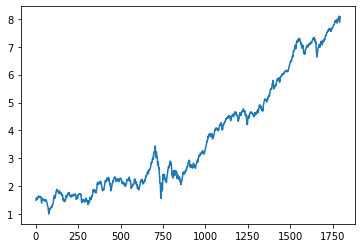

In [24]:
plt.plot(np.log(df['P']))

In [25]:
def calc_slope(df, col='P'):
    X = df['Date'].values.reshape(-1,1)
    y = np.log(df[col]).values
    lr = LinearRegression().fit(X, y)
    b = lr.intercept_
    a =lr.coef_
    y_ = X*a+b
    return y_, y, X, a, b


In [26]:
y_, y, X, a, b = calc_slope(df)

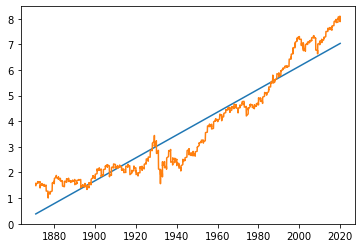

In [27]:
plt.plot(X, y_)
plt.plot(X, y)

log(P)=a\*time+b  
P = exp(a\*time+b) = exp(b)\*exp(a\*time) = B\*(q^time)  
q = exp(a)  

In [28]:
np.exp(a)

array([1.0456331])

So the market does 4.5% with inflation

In [29]:
y_, y, X, a, b = calc_slope(df, 'Price')

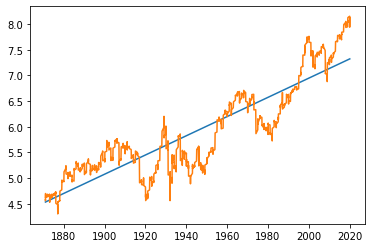

In [30]:
plt.plot(X, y_)
plt.plot(X, y)

In [31]:
np.exp(a)

array([1.01887881])

So the market does ~2% without inflation

What if we look at the last 100 years

In [32]:
df_100 = df[df['Date']>1920]

In [33]:
y_, y, X, a, b = calc_slope(df_100, 'P')

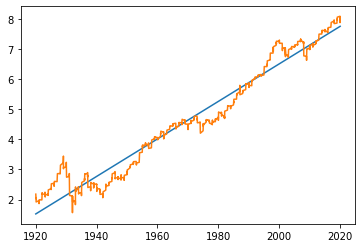

In [34]:
plt.plot(X, y_)
plt.plot(X, y)

In [35]:
np.exp(a)

array([1.06433833])

In [36]:
y_, y, X, a, b = calc_slope(df_100, 'Price')

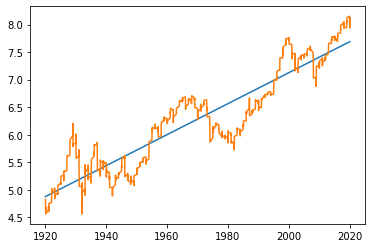

In [37]:
plt.plot(X, y_)
plt.plot(X, y)

In [38]:
np.exp(a)

array([1.0285191])

In [41]:
np.exp(a)[0]**100

16.643168981473156

In [47]:
np.exp(y_[-1])/np.exp(y_[0])

array([16.67127304])

## Using CAPE

In [50]:
df.columns

Index(['Date', 'P', 'D', 'E', 'CPI', 'Fraction', 'Rate GS10', 'Price',
       'Dividend', 'Price.1', 'Earnings', 'Earnings.1', 'CAPE', 'Unnamed: 13',
       'TR CAPE', 'Unnamed: 15', 'Yield', 'Returns', 'Returns.1',
       'Real Return', 'Real Return.1', 'Returns.2', 'Adj Close Diff'],
      dtype='object')

In [69]:
df = df.dropna(subset=['CAPE'])

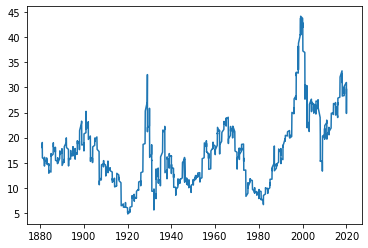

In [79]:
plt.plot(df['Date'], df['CAPE'])

In [231]:
df['MA'] = df['Adj Close Diff'].rolling(window=36).mean()

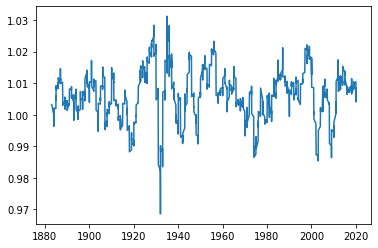

In [232]:
plt.plot(df['Date'], df['MA'])

## Interest rates

In [ ]:
requests.get()

In [139]:
dimensions = "IRLT" # "IRLT+IR3TIB+IRSTCI+CCUS"
flat = "" # "&dimensionAtObservation=allDimensions"
url = f"https://stats.oecd.org/SDMX-JSON/data/MEI_FIN/{dimensions}.USA.M/all?startTime=1950-01&endTime=2022-01{flat}"
# url = "https://stats.oecd.org/SDMX-JSON/data/MEI_FIN/IRLT.USA.M/all?startTime=1950-01&endTime=2022-01"


In [141]:
r = requests.get(url)

In [143]:
j = r.json()

In [144]:
dataset = j['dataSets'][0]

In [146]:
series = dataset['series']

In [210]:
observations = series['observations']

In [211]:
interest_df = pd.DataFrame(observations).T

In [163]:
structure = j['structure']

In [167]:
dimensions = structure['dimensions']

In [181]:
observations = dimensions['observation'][0]

In [182]:
date_df = pd.DataFrame(observations['values'])

In [212]:
interest_df.index = interest_df.index.astype('int64')

In [213]:
interest_df['date'] = date_df['id']

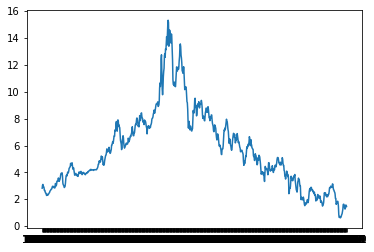

In [216]:
plt.plot(interest_df['date'], interest_df[0])

# Using MacroTrends

https://www.macrotrends.net/2324/sp-500-historical-chart-data